In [54]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')


### Load Data

In [55]:
SEISMIC_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingSeismic.hdf5'
PRESSURE_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5'

In [56]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [57]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [58]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: ../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [59]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [60]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25

t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func = interp1d(t_n, n_cnts, kind='linear')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [61]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func(t_p_interpolated) # interpolated number of earthquakes 

[   0 1087 1550 1972 2192 2521 3163 3668]
8


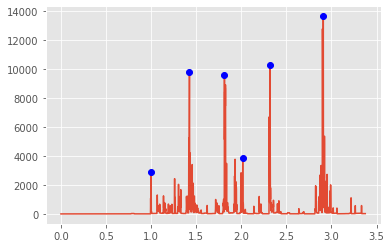

In [62]:
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
peak_indexs=pk_indxs(empirical_rate,trshd=0.2, min_dist=100)
plt.plot(t_p_interpolated, empirical_rate)
plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')
peak_indexs=np.insert(peak_indexs,0,0)
peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_p_interpolated)-1)
print(peak_indexs)
print(np.size(peak_indexs))

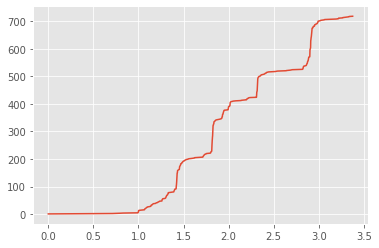

In [63]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [64]:
train_end = np.where(t_p_interpolated > 1.3)[0][0]

### Define site constants

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [65]:
params = torch.FloatTensor([[0.5,1e-2,1e-4]])


# mu_minus_alpha_mesh = torch.linspace(0.1,1.0,101)
# rate_coeff_mesh = 10 ** torch.linspace(-4,-1,101)
# grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

# params = torch.stack([
#     grid_mu.flatten(),
#     grid_rate.flatten(),
#     163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
# ]).T

# params.requires_grad_()



### Run Model

In [75]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }
# from model import CRSModel
from model_v2 import CRSModel
model = CRSModel(site_info)

Visualize a sample

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [39]:
#criterion = nn.MSELoss(reduction='sum')

In [40]:
#loss = criterion(Nt[:,1:], n_target[None,:])
#loss.item()

In [41]:
#loss.backward()

In [79]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }

In [170]:
np.size(peak_indexs)



8

In [185]:
from model import CRSModel
import torch.optim as optim
import torch.nn.functional as F
model = CRSModel(site_info)

params = torch.FloatTensor([[0.5,1e-2,0.0005]])
# params = torch.FloatTensor([[5.0000e-01, 9.9910e-03, 5.1348e-05]])
params.requires_grad=True
params.register_hook(lambda g: F.normalize(g))

initial_lr = 0.00005
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(params=[params],lr=initial_lr,momentum=0.5)
for epoch in range(500):
    R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
    # for i in range(np.size(peak_indexs)-4): # only using partial data for training
    for i in range(0,6): # only using the first 5 peaks for training
             mpa_yr2pa_s = 1e6 / 365.25 / 86400
             site_info = {
                          'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
                          'tectonic_normal_stressing_rate' : 0, # Pa/s
                          'sigma' : 30 * 1e6, # Pa
                          'biot' : 0.3, # dimensionless
                          #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
                          'background_rate' : empirical_rate[peak_indexs[i]+1] / 365.25 / 86400, # event/second,
                          'init_delta_t' : delta_t[0].item() }
             model = CRSModel(site_info)
             p0 = torch.FloatTensor(p)[peak_indexs[i]+1:peak_indexs[i+1]]
             dpdt0 = torch.FloatTensor(dpdt)[peak_indexs[i]+1:peak_indexs[i+1]]
             delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
             
             Rt, Nt = model(params, p0, dpdt0, delta_t0)
             #print(empirical_rate[peak_indexs[i]],)
             R0=torch.cat((R0,Rt),dim=-1)
             #print(N0.detach()[0][-1])
             Nt=torch.add(Nt,N0.detach()[0][-1])
             #print(N0.detach())
             N0=torch.cat((N0,Nt),dim=-1)
             n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
             n_target0=torch.cat((n_target0,n_target),dim=-1)
             #print(n_target0.detach().size(),(N0[:,1:]).squeeze().detach().size())
             

    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    
    
    #print((N0[:,1:]).squeeze().detach().numpy(),n_target0.detach().numpy())
    loss = criterion((N0[:,1:]).squeeze(), n_target0)
    lr = initial_lr
    if epoch == 0:
        initial_loss = loss
    if loss < 0.01*initial_loss:
        lr = 0.000001
        optimizer = optim.SGD(params=[params],lr=lr,momentum=0.1)
        # print('switching to smaller lr')
    if loss < 0.005* initial_loss:
        lr = 0.0000001
        optimizer = optim.SGD(params=[params],lr=lr,momentum=0.1)
    if epoch > 200:
        lr = 0.00000001
        optimizer = optim.SGD(params=[params],lr=lr,momentum=0)
    if epoch % 5 == 0:
        # print('initial_loss: ' + str(initial_loss))
        print('step: ' + str(epoch) + ' loss is ' + str(loss.item()) + ' lr is ' + str(lr))
        # print(params.grad)
        display(params.grad)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Nt.shape

step: 0 loss is 2387120640.0 lr is 5e-05


None

step: 5 loss is 15690716.0 lr is 1e-06


tensor([[6.3513e-05, 1.6229e-02, 9.9987e-01]])

step: 10 loss is 11277730.0 lr is 1e-07


tensor([[2.5175e-05, 8.0574e-03, 9.9997e-01]])

step: 15 loss is 10793163.0 lr is 1e-07


tensor([[2.5025e-05, 8.0149e-03, 9.9997e-01]])

step: 20 loss is 10320430.0 lr is 1e-07


tensor([[2.4875e-05, 7.9723e-03, 9.9997e-01]])

step: 25 loss is 9859574.0 lr is 1e-07


tensor([[2.4727e-05, 7.9296e-03, 9.9997e-01]])

step: 30 loss is 9410648.0 lr is 1e-07


tensor([[2.4581e-05, 7.8869e-03, 9.9997e-01]])

step: 35 loss is 8973724.0 lr is 1e-07


tensor([[2.4435e-05, 7.8442e-03, 9.9997e-01]])

step: 40 loss is 8548833.0 lr is 1e-07


tensor([[2.4291e-05, 7.8013e-03, 9.9997e-01]])

step: 45 loss is 8136049.0 lr is 1e-07


tensor([[2.4149e-05, 7.7584e-03, 9.9997e-01]])

step: 50 loss is 7735405.5 lr is 1e-07


tensor([[2.4008e-05, 7.7154e-03, 9.9997e-01]])

step: 55 loss is 7346959.0 lr is 1e-07


tensor([[2.3869e-05, 7.6723e-03, 9.9997e-01]])

step: 60 loss is 6970815.5 lr is 1e-07


tensor([[2.3732e-05, 7.6292e-03, 9.9997e-01]])

step: 65 loss is 6606978.0 lr is 1e-07


tensor([[2.3596e-05, 7.5859e-03, 9.9997e-01]])

step: 70 loss is 6255504.0 lr is 1e-07


tensor([[2.3463e-05, 7.5425e-03, 9.9997e-01]])

step: 75 loss is 5916462.0 lr is 1e-07


tensor([[2.3333e-05, 7.4990e-03, 9.9997e-01]])

step: 80 loss is 5589944.5 lr is 1e-07


tensor([[2.3205e-05, 7.4553e-03, 9.9997e-01]])

step: 85 loss is 5275986.0 lr is 1e-07


tensor([[2.3080e-05, 7.4115e-03, 9.9997e-01]])

step: 90 loss is 4974634.5 lr is 1e-07


tensor([[2.2958e-05, 7.3676e-03, 9.9997e-01]])

step: 95 loss is 4685972.5 lr is 1e-07


tensor([[2.2839e-05, 7.3235e-03, 9.9997e-01]])

step: 100 loss is 4410055.0 lr is 1e-07


tensor([[2.2725e-05, 7.2792e-03, 9.9997e-01]])

step: 105 loss is 4146945.0 lr is 1e-07


tensor([[2.2614e-05, 7.2346e-03, 9.9997e-01]])

step: 110 loss is 3896706.25 lr is 1e-07


tensor([[2.2509e-05, 7.1898e-03, 9.9997e-01]])

step: 115 loss is 3659397.5 lr is 1e-07


tensor([[2.2409e-05, 7.1448e-03, 9.9997e-01]])

step: 120 loss is 3435070.5 lr is 1e-07


tensor([[2.2316e-05, 7.0994e-03, 9.9997e-01]])

step: 125 loss is 3223820.0 lr is 1e-07


tensor([[2.2230e-05, 7.0537e-03, 9.9998e-01]])

step: 130 loss is 3025687.75 lr is 1e-07


tensor([[2.2152e-05, 7.0075e-03, 9.9998e-01]])

step: 135 loss is 2840736.75 lr is 1e-07


tensor([[2.2084e-05, 6.9608e-03, 9.9998e-01]])

step: 140 loss is 2669056.0 lr is 1e-07


tensor([[2.2028e-05, 6.9136e-03, 9.9998e-01]])

step: 145 loss is 2510692.5 lr is 1e-07


tensor([[2.1985e-05, 6.8657e-03, 9.9998e-01]])

step: 150 loss is 2365724.5 lr is 1e-07


tensor([[2.1959e-05, 6.8169e-03, 9.9998e-01]])

step: 155 loss is 2234210.5 lr is 1e-07


tensor([[2.1954e-05, 6.7672e-03, 9.9998e-01]])

step: 160 loss is 2116221.75 lr is 1e-07


tensor([[2.1973e-05, 6.7161e-03, 9.9998e-01]])

step: 165 loss is 2011834.625 lr is 1e-07


tensor([[2.2024e-05, 6.6635e-03, 9.9998e-01]])

step: 170 loss is 1921117.875 lr is 1e-07


tensor([[2.2115e-05, 6.6089e-03, 9.9998e-01]])

step: 175 loss is 1844143.5 lr is 1e-07


tensor([[2.2261e-05, 6.5516e-03, 9.9998e-01]])

step: 180 loss is 1780975.375 lr is 1e-07


tensor([[2.2479e-05, 6.4906e-03, 9.9998e-01]])

step: 185 loss is 1731697.875 lr is 1e-07


tensor([[2.2800e-05, 6.4244e-03, 9.9998e-01]])

step: 190 loss is 1696377.625 lr is 1e-07


tensor([[2.3271e-05, 6.3508e-03, 9.9998e-01]])

step: 195 loss is 1675092.375 lr is 1e-07


tensor([[2.3979e-05, 6.2653e-03, 9.9998e-01]])

step: 200 loss is 1667916.25 lr is 1e-07


tensor([[2.5084e-05, 6.1599e-03, 9.9998e-01]])

step: 205 loss is 1674922.75 lr is 1e-07


tensor([[2.6945e-05, 6.0166e-03, 9.9998e-01]])

step: 210 loss is 1696192.75 lr is 1e-07


tensor([[3.0530e-05, 5.7870e-03, 9.9998e-01]])

step: 215 loss is 1731801.625 lr is 1e-07


tensor([[3.9700e-05, 5.2776e-03, 9.9999e-01]])

step: 220 loss is 1781827.75 lr is 1e-07


tensor([[1.0381e-04, 2.0162e-03, 1.0000e+00]])

step: 225 loss is 1793577.75 lr is 1e-07


tensor([[ 2.2747e-04, -4.1878e-03,  9.9999e-01]])

step: 230 loss is 1781844.125 lr is 1e-07


tensor([[ 4.6255e-04, -3.0362e-02, -9.9954e-01]])

step: 235 loss is 1793591.0 lr is 1e-07


tensor([[ 2.2785e-04, -4.2070e-03,  9.9999e-01]])

step: 240 loss is 1781859.125 lr is 1e-07


tensor([[ 4.6043e-04, -3.0256e-02, -9.9954e-01]])

step: 245 loss is 1793610.0 lr is 1e-07


tensor([[ 2.2830e-04, -4.2295e-03,  9.9999e-01]])

step: 250 loss is 1781875.75 lr is 1e-07


tensor([[ 4.5837e-04, -3.0152e-02, -9.9955e-01]])

step: 255 loss is 1793625.875 lr is 1e-07


tensor([[ 2.2869e-04, -4.2487e-03,  9.9999e-01]])

step: 260 loss is 1781890.375 lr is 1e-07


tensor([[ 4.5644e-04, -3.0056e-02, -9.9955e-01]])

step: 265 loss is 1793641.0 lr is 1e-07


tensor([[ 2.2908e-04, -4.2687e-03,  9.9999e-01]])

step: 270 loss is 1781905.5 lr is 1e-07


tensor([[ 4.5460e-04, -2.9963e-02, -9.9955e-01]])

step: 275 loss is 1793655.0 lr is 1e-07


tensor([[ 2.2946e-04, -4.2876e-03,  9.9999e-01]])

step: 280 loss is 1781920.375 lr is 1e-07


tensor([[ 4.5230e-04, -2.9849e-02, -9.9955e-01]])

step: 285 loss is 1793674.125 lr is 1e-07


tensor([[ 2.2991e-04, -4.3099e-03,  9.9999e-01]])

step: 290 loss is 1781935.625 lr is 1e-07


tensor([[ 4.5006e-04, -2.9736e-02, -9.9956e-01]])

step: 295 loss is 1793691.125 lr is 1e-07


tensor([[ 2.3034e-04, -4.3317e-03,  9.9999e-01]])

tensor([[5.0000e-01, 9.9910e-03, 5.1348e-05]], requires_grad=True)


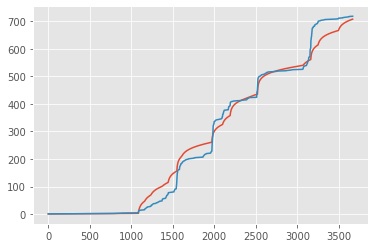

In [46]:
# Using Han's output, don't run this cell
plt.plot((N0[:,1:]).squeeze().detach().numpy())
plt.plot(n_target0)
print(params)

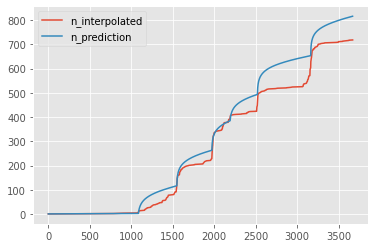

In [184]:
# params = torch.FloatTensor([[5.0009e-01,2.7316e-03,3.0530e-04,5.0000e-04]])
# Rt, Nt = model(params, p, dpdt, delta_t)
# plt.plot(Nt.data.detach().numpy()[0])
# # params = torch.FloatTensor([[5.0009e-01,2.7316e-03,163.7424,5.0000e-04]])
# Rt, Nt = model(params, p, dpdt, delta_t)
# plt.plot(Nt.data.detach().numpy()[0])
R0, N0 = torch.ones(1, 1),torch.ones(1, 1),
for i in range(np.size(peak_indexs)-1):
    mpa_yr2pa_s = 1e6 / 365.25 / 86400
    site_info = {
        'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
        'tectonic_normal_stressing_rate' : 0, # Pa/s
        'sigma' : 30 * 1e6, # Pa
        'biot' : 0.3, # dimensionless
        #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
        'background_rate' : empirical_rate[peak_indexs[min(i,6)]] / 365.25 / 86400, # event/second,
        'init_delta_t' : delta_t[0].item() }
    model = CRSModel(site_info)
    p0 = torch.FloatTensor(p)[peak_indexs[i]+1:peak_indexs[i+1]]
    dpdt0 = torch.FloatTensor(dpdt)[peak_indexs[i]+1:peak_indexs[i+1]]
    delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
             
    Rt, Nt = model(params, p0, dpdt0, delta_t0)
    #print(empirical_rate[peak_indexs[i]],)
    R0=torch.cat((R0,Rt),dim=-1)
    #print(N0.detach()[0][-1])
    Nt=torch.add(Nt,N0.detach()[0][-1])
    #print(N0.detach())
    N0=torch.cat((N0,Nt),dim=-1)
    # n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
    # n_target0=torch.cat((n_target0,n_target),dim=-1)
plt.plot(n_interpolated,label="n_interpolated")
plt.plot((N0[:,1:]).squeeze().detach().numpy(),label="n_prediction")
plt.legend(loc="upper left")
plt.show()

In [166]:
params

tensor([[5.0000e-01, 9.9879e-03, 7.7161e-05]], requires_grad=True)